## Intel Capital data analysis

In [10]:
import numpy as np
import json
import pandas as pd
from datetime import datetime

# Attributes explain one by one 
| Attribute | Explanation |
| --------- | ----------- |
| created_at | Time created |
| id | Tweet ID |
| id_str | Tweet ID (string) |
| full_text | Tweet text |
| truncated | Boolean attribute indicating whether the value of the text parameter was truncated |
| display_text_range | Display text range |
| entities | Object containing information about entities in the tweet, including hashtags, symbols, user mentions, and URLs |
| source | Utility used to post the tweet, as an HTML-formatted string |
| in_reply_to_status_id | If the represented tweet is a reply, this field will contain the integer representation of the original tweet’s ID |
| in_reply_to_status_id_str | String representation of in_reply_to_status_id |
| in_reply_to_user_id | If the represented tweet is a reply, this field will contain the integer representation of the original tweet’s author ID |
| in_reply_to_user_id_str | String representation of in_reply_to_user_id |
| in_reply_to_screen_name | If the represented tweet is a reply, this field will contain the screen name of the original tweet’s author |
| user | User object |
| geo | Same as coordinates |
| coordinates | Nullable. Represents the geographic location of this tweet as reported by the user or client application |
| place | Nullable. When present, indicates that the tweet is associated with a place |
| contributors | Contributors |
| is_quote_status | Boolean indicating whether this tweet is a quoted tweet |
| quoted_status_id | This field contains the integer value tweet ID of the quoted tweet |
| quoted_status_id_str | String representation of quoted_status_id |
| quoted_status_permalink | Whether or not the quoted tweet is permanently quoted |
| quoted_status | Boolean indicating whether this is a quoted tweet |
| retweet_count | Number of times this tweet has been retweeted |
| favorite_count | Indicates approximately how many times this tweet has been liked by Twitter users |
| favorited | Boolean indicating whether this tweet has been liked by the authenticating user |
| retweeted | Boolean indicating whether this tweet has been retweeted by the authenticating user |
| possibly_sensitive | This field indicates whether the tweet content may be recognized as sensitive |
| lang | Language used in this tweet, like 'en' |


The attribute we want to use:
| Attribute | Explanation |
| --------- | ----------- |
| created_at | Time created |
| full_text | Tweet text |
| hashtags | List of hashtags used in the tweet |
| people_mentions | List of users mentioned in the tweet |
| in_reply_to_status_id | If the represented tweet is a reply, this field will contain the integer representation of the original tweet’s ID |
| retweet_count | Number of times this tweet has been retweeted |
| retweeted | Boolean indicating whether this tweet has been retweeted by the authenticating user |
| favorite_count | Indicates approximately how many times this tweet has been liked by Twitter users |
| favorited | Boolean indicating whether this tweet has been liked by the authenticating user |
| user | User object |


In [11]:
import jsonlines
tweets = []
with jsonlines.open('ICtweets.json') as reader:
    tweets = []
    for obj in reader:
        new_dic = {}
        # Convert the string to a datetime object
        date_obj = datetime.strptime(obj['created_at'], '%a %b %d %H:%M:%S %z %Y')
        # Format the output in the "dd-mm-yyyy" format
        formatted_date = date_obj.strftime('%d-%m-%Y')
        new_dic['time'] = formatted_date

        new_dic['user'] = obj['user']['screen_name']

        new_dic['text'] = obj['full_text']
        
        hastags = []
        for hashtag in obj['entities']['hashtags']:
            hastags.append(hashtag['text'])
        new_dic['hashtag'] = hastags

        user_mentions = []

        for user in obj['entities']['user_mentions']:
            users = {}
            users['user_id'] = user['id']
            users['screen_name'] = user['screen_name']
            user_mentions.append(users)
        new_dic['user_mentions'] = user_mentions
        
        new_dic['retweeted'] = obj['retweeted']
        new_dic['retweet_count'] = obj['retweet_count']

        new_dic['favorited'] = obj['favorited']
        new_dic['favorite_count'] = obj['favorite_count']

        new_dic['in_reply_to_user_id'] = obj['in_reply_to_user_id']
            
        #print(new_dic.keys())

        tweets.append(new_dic)
        #

In [12]:
# Write data line by line to csv file
import csv

# Define the field names (i.e., the keys in the dictionaries)
fieldnames = ['time', 'user', 'text', 'hashtag', 'user_mentions', 'retweeted', 'retweet_count', 'favorited', 'favorite_count', 'in_reply_to_user_id']

# Open a CSV file for writing
with open('ICtweets.csv', 'w', newline='') as csvfile:

    # Create a writer object
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # Write the header row
    writer.writeheader()

    # Write the data rows
    for row in tweets:
        writer.writerow(row)

# Check the quality of data

### Use BART (Bidirectional and Auto-Regressive Transformers) model 

BART is a denoising self-encoder designed for pre-training sequence-to-sequence models proposed by Facebook.

BART is trained by:

(1) corrupting the text using an arbitrary noise function 

(2) learning the model to reconstruct the original text.

In [5]:
from transformers import BartTokenizer, BartForConditionalGeneration
import torch

new_tweets_list = []
# Load the BART model and tokenizer
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')

# Enable GPU acceleration if available
device = torch.device('cpu')

text = "Let's use this powerful NLP tool which creat by Facebook"
    
# Encode and truncate the input text
input_ids = tokenizer.encode(text, return_tensors='pt', max_length=1024, truncation=True)

# Generate a summary
summary_ids = model.generate(input_ids, num_beams=4, max_length=100, early_stopping=True)
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
summary

"Let's use this powerful NLP tool which has been developed by Facebook"

### ROUGE (Recall-Oriented Understudy for Gisting Evaluation)

ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a set of metrics used to evaluate the similarity between the generated summary or translated text and the original text.ROUGE metrics are commonly used to evaluate the performance of automated summarization or translation systems.

ROUGE metrics are based on two concepts: recall and precision, both of which are classical concepts in the field of information retrieval. In the ROUGE metric, recall is used to evaluate the part of the generated text that overlaps with the original text, and precision is used to evaluate the difference between the generated text and the original text.

In [6]:
from rouge import Rouge

# Define the reference and generated lists of strings
reference_list = "Let's use this powerful NLP tool which creat by Facebook"
generated_list = "Let's use this powerful NLP tool which has been developed by Facebook"

# Concatenate the strings in each list with newline characters
reference_text = "\n".join(reference_list)
generated_text = "\n".join(generated_list)

# Initialize the ROUGE object
rouge = Rouge()

# Calculate the ROUGE scores
scores = rouge.get_scores(generated_text, reference_text)

# Print the scores
scores


[{'rouge-1': {'f': 0.8380952331501135,
   'p': 0.7586206896551724,
   'r': 0.9361702127659575},
  'rouge-2': {'f': 0.7766990241832407,
   'p': 0.7017543859649122,
   'r': 0.8695652173913043},
  'rouge-l': {'f': 0.9361702077863288, 'p': 0.88, 'r': 1.0}}]

In [68]:
tweets_text_list = []
for tweet in tweets:
    tweets_text_list.append(tweet['text'])

In [83]:
from transformers import BartTokenizer, BartForConditionalGeneration
import torch

new_tweets_list = []
# Load the BART model and tokenizer
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')

# Enable GPU acceleration if available
device = torch.device('cpu')

# Iterate over the tweets
for tweet in tweets:
    # Get the text from the tweet dictionary
    text = tweet['text']
    
    # Encode and truncate the input text
    input_ids = tokenizer.encode(text, return_tensors='pt', max_length=1024, truncation=True)
    
    # Generate a summary
    summary_ids = model.generate(input_ids, num_beams=4, max_length=100, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    
    # Add the generated summary to new_tweets_list
    new_tweets_list.append(summary)


In [84]:
from rouge import Rouge

# Define the reference and generated lists of strings
reference_list = tweets_text_list
generated_list = new_tweets_list

# Concatenate the strings in each list with newline characters
reference_text = "\n".join(reference_list)
generated_text = "\n".join(generated_list)

# Initialize the ROUGE object
rouge = Rouge()

# Calculate the ROUGE scores
scores = rouge.get_scores(generated_text, reference_text)

# Print the scores
scores


[{'rouge-1': {'r': 0.9845947756195579,
   'p': 0.9722222222222222,
   'f': 0.9783693793596008},
  'rouge-2': {'r': 0.9732205778717407,
   'p': 0.9647223192455466,
   'f': 0.9689528102956585},
  'rouge-l': {'r': 0.9845947756195579,
   'p': 0.9722222222222222,
   'f': 0.9783693793596008}}]

### Data Integrity Testing

In [7]:
# Missing value and outlier detection

import pandas as pd

# Load dataset
df = pd.read_csv('ICtweets.csv')

# Check for missing values
missing_values = df.isnull()

# Count the number of missing values for each column
num_missing = missing_values.sum()

print(num_missing)



time                    0
user                    0
text                    0
hashtag                 0
user_mentions           0
retweeted               0
retweet_count           0
favorited               0
favorite_count          0
in_reply_to_user_id    74
dtype: int64


There are no missing values except for in_reply_to_user_id, but we can't remove this column, which is very useful to discover the interaction between intel capital and other users. The best thing to do is to fill all this column with 0.

In [8]:
# Fill missing values with 0
df_filled = df.fillna(0)

missing_values = df_filled.isnull()

# Count the number of missing values for each column
num_missing = missing_values.sum()

print(num_missing)


time                   0
user                   0
text                   0
hashtag                0
user_mentions          0
retweeted              0
retweet_count          0
favorited              0
favorite_count         0
in_reply_to_user_id    0
dtype: int64


# Topic modeling (LDA)

Identify topics by the frequency of words and phrases in the Twitter data to understand the topics and industry trends that companies focus on.

In [9]:
import re

# Print head
df_filled.head()

# Remove punctuation
df_filled['text_processed'] = df_filled['text'].map(lambda x: re.sub('[#,\.!?@]', '', x))
# Convert the titles to lowercase
df_filled['text_processed'] = df_filled['text_processed'].map(lambda x: x.lower())

# Important!
url_pattern = re.compile(r'http\S+|www.\S+')
df_filled['text_processed'] = df_filled['text_processed'].str.replace(url_pattern, '')
# df_filled['text_processed'] = df_filled['text_processed'][:df_filled['text_processed'].rfind(' ')]

# Print out the first rows of papers
df_filled['text_processed'].head()

0    for a third year in a row immuta has been awar...
1    cybersecurity company jupiterone announced int...
2    learn more about how securityscorecard’s ratin...
3    securityscorecard co-founder &amp; ceo aleksan...
4    intel capital's managing director sunil kurkur...
Name: text_processed, dtype: object

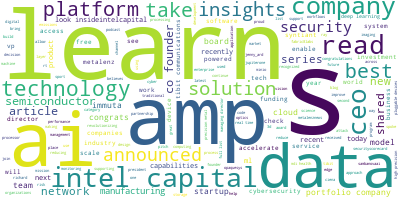

In [10]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df_filled['text_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [11]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from pprint import pprint
from torch.nn.utils.rnn import pad_sequence

In [12]:

# Example documents
documents = df_filled['text_processed']

# Fine-tune BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

tokenized_docs = [tokenizer.encode(doc, add_special_tokens=True, truncation=True) for doc in documents]

# Pad the sequences to the same length
padded_docs = pad_sequence([torch.tensor(doc) for doc in tokenized_docs], batch_first=True)
# Move the padded sequences to the specified device
padded_docs = padded_docs.to(device)

input_ids = torch.tensor(padded_docs).to(device)
outputs = model(input_ids)
topic_representations = outputs[0].detach().cpu().numpy()

# Topic modeling using LDA
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(documents)

lda = LatentDirichletAllocation(n_components=2, random_state=42)
lda.fit(X)

# Print topics
pprint(lda.components_)
pprint(vectorizer.get_feature_names_out())

pprint(topic_representations)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

array([[0.50190142, 1.49857306, 1.49855566, ..., 3.49783642, 6.52440195,
        1.49852891],
       [1.49809858, 0.50142694, 0.50144434, ..., 0.50216358, 2.47559805,
        0.50147109]])
array(['10', '11th', '14m', ..., 'you', 'your', 'zero'], dtype=object)
array([[ 0.1769251 , -0.11031599],
       [ 0.173343  , -0.12620237],
       [ 0.11912553, -0.05396373],
       [ 0.15451208, -0.10328749],
       [ 0.11637107, -0.18793945],
       [ 0.20415914, -0.0683369 ],
       [ 0.04205194, -0.14249834],
       [ 0.11260772,  0.04208587],
       [ 0.13544814, -0.0317614 ],
       [ 0.16817765, -0.01315293],
       [ 0.04438366,  0.0886673 ],
       [ 0.19122118, -0.07883659],
       [ 0.16646351, -0.09883058],
       [ 0.15437551, -0.05724324],
       [ 0.06380187,  0.10312678],
       [ 0.10940823, -0.15078747],
       [ 0.03431212, -0.19142026],
       [ 0.12456948, -0.17762613],
       [ 0.18020211, -0.20820627],
       [ 0.13074243, -0.05399366],
       [ 0.12413   , -0.14539517],
     

In [19]:
!pip install nltk
!pip install pyLDAvis
!pip install gensim

In [17]:
# LDA without BERT

import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'learn', 'take', 'best', 'look', 'read', 'new'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = df_filled.text_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['third', 'year', 'row', 'immuta', 'awarded', 'one', 'forbes', 'america', 'startup', 'employers', 'congratulations', 'year', 'ranked', 'th', 'among', 'list', 'employers', 'see', 'full', 'list']


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ricole/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2)]


In [19]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.019*"company" + 0.013*"amp" + 0.013*"ai" + 0.010*"data" + 0.009*"ceo" + '
  '0.009*"capabilities" + 0.009*"tibit" + 0.007*"manufacturing" + '
  '0.007*"models" + 0.007*"reducing"'),
 (1,
  '0.016*"amp" + 0.012*"capital" + 0.012*"intel" + 0.011*"ceo" + 0.009*"ai" + '
  '0.009*"founder" + 0.007*"platform" + 0.007*"congrats" + 0.007*"ultrasound" '
  '+ 0.007*"code"'),
 (2,
  '0.012*"intel" + 0.011*"technology" + 0.010*"cloud" + 0.009*"storage" + '
  '0.009*"received" + 0.009*"year" + 0.009*"amp" + 0.009*"insights" + '
  '0.009*"development" + 0.008*"metalenz"'),
 (3,
  '0.013*"learning" + 0.013*"devices" + 0.013*"cloud" + 0.008*"ai" + '
  '0.008*"deep" + 0.007*"data" + 0.007*"see" + 0.007*"network" + 0.007*"ciena" '
  '+ 0.007*"allow"'),
 (4,
  '0.018*"data" + 0.015*"immuta" + 0.015*"security" + 0.013*"amp" + '
  '0.012*"company" + 0.011*"ai" + 0.010*"portfolio" + 0.009*"list" + '
  '0.007*"product" + 0.007*"year"'),
 (5,
  '0.014*"data" + 0.013*"ai" + 0.012*"semiconductor" + 0.

In [20]:
import pyLDAvis.gensim

# Enable notebook mode
pyLDAvis.enable_notebook()

# Create and fit the LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)
lda_model.update(corpus)

# Prepare the data for visualization
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

# Display the visualization
pyLDAvis.display(LDAvis_prepared)


/Users/ricole/opt/anaconda3/envs/berylenv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


# Entity identification

Identify entities such as companies, people, and locations mentioned in the tweet data to understand which areas or companies the company is associated with.

In [1]:
import pandas as pd
import re

In [34]:
# Prepare the data in Entity identification
# Load dataset
df = pd.read_csv('ICtweets.csv')

# Remove punctuation
df['text_processed'] = df['text'].map(lambda x: re.sub('[#,\.!?@]', '', x))

# Important!
url_pattern = re.compile(r'http\S+|www.\S+')
df['text_processed'] = df['text_processed'].str.replace(url_pattern, '')
# df_filled['text_processed'] = df_filled['text_processed'][:df_filled['text_processed'].rfind(' ')]

text = '.'.join(df['text_processed'])

# Define the words to be dropped
words_to_drop = ['learn', 'AI', 'Read']

# Remove the words from the text
for word in words_to_drop:
    text = re.sub(r'\b{}\b'.format(word), '', text, flags=re.IGNORECASE)

<>:6: DeprecationWarning: invalid escape sequence \.
<>:6: DeprecationWarning: invalid escape sequence \.
/var/folders/j_/84vxm1c91vd09r8t20wzdpkm0000gn/T/ipykernel_82129/2531494349.py:6: DeprecationWarning: invalid escape sequence \.
  df['text_processed'] = df['text'].map(lambda x: re.sub('[#,\.!?@]', '', x))


In [35]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

# text = "John Smith lives in!! #New York City, and works'' at Google."

# Tokenize the text into words
tokens = nltk.word_tokenize(text)

# Apply Part-of-Speech (POS) tagging to the tokens
pos_tags = nltk.pos_tag(tokens)

# Apply named entity recognition to the POS-tagged tokens
ne_chunks = nltk.ne_chunk(pos_tags)

# Loop over each entity chunk and print its label and text
for chunk in ne_chunks:
    if hasattr(chunk, "label"):
        print(chunk.label(), " ".join(c[0] for c in chunk))


[nltk_data] Downloading package punkt to /Users/ricole/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ricole/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/ricole/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/ricole/nltk_data...
[nltk_data]   Package words is already up-to-date!


PERSON Immuta
ORGANIZATION Forbes
ORGANIZATION America
PERSON Best Startup Employers
ORGANIZATION AmericasBestEmployers
ORGANIZATION JupiterOne
PERSON Tines
ORGANIZATION SecurityScorecard
ORGANIZATION CEO Aleksandr Yampolskiy
ORGANIZATION Intel Capital
PERSON Sunil Kurkure
ORGANIZATION SecurityScorecard
ORGANIZATION InsideIntelCapital
ORGANIZATION LSEGplc Data
PERSON Analytics CEO Andrea Remyn Stone
GPE Japan
ORGANIZATION RIKEN_en
ORGANIZATION SambaNovaAI
ORGANIZATION DataScale
PERSON Fujitsu_Global
ORGANIZATION Fugaku
ORGANIZATION AyarLabs
ORGANIZATION HPC
ORGANIZATION SandeepAkkaraju
ORGANIZATION PSQHnews
GPE POCUS
ORGANIZATION SambaNovaAI
ORGANIZATION SambaNova
ORGANIZATION GenerativeAI
ORGANIZATION SambaNova Suite
ORGANIZATION VentureBeat
PERSON Immuta
ORGANIZATION ServiceNow
PERSON Immuta
PERSON Qualcomm
PERSON Prophesee
GPE Software
PERSON Qualcomm
ORGANIZATION Snapdragon
GPE Machine
ORGANIZATION EUV Tech
ORGANIZATION Intel Capital
LOCATION Sean Doyle
ORGANIZATION EUV
ORGANIZATIO

In [27]:
!pip install spacy
!python -m spacy download en_core_web_sm

DEPRECATION: https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.2.0/en_core_web_sm-3.2.0-py3-none-any.whl#egg=en_core_web_sm==3.2.0 contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 8.4 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [36]:
import spacy
from spacy import displacy

# load the pre-trained English language model
nlp = spacy.load("en_core_web_sm")

# # define the input text
# text = "John Smith lives in New York City and works at Google."

# apply named entity recognition to the input text
doc = nlp(text)

# visualize the entities using the displacy function
displacy.render(doc, style="ent", jupyter=True)


/Users/ricole/opt/anaconda3/envs/berylenv/lib/python3.9/site-packages/spacy/displacy/__init__.py:65: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [8]:
!pip install wordcloud

/Users/ricole/opt/anaconda3/envs/berylenv/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/Users/ricole/opt/anaconda3/envs/berylenv/lib/python3.9/site-packages/wordcloud/wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/ricole/opt/anaconda3/envs/berylenv/lib/python3.9/site-packages/wordcloud/wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/ricole/opt/anaconda3/envs/berylenv/lib/python3.9/site-packages/wordcloud/wor

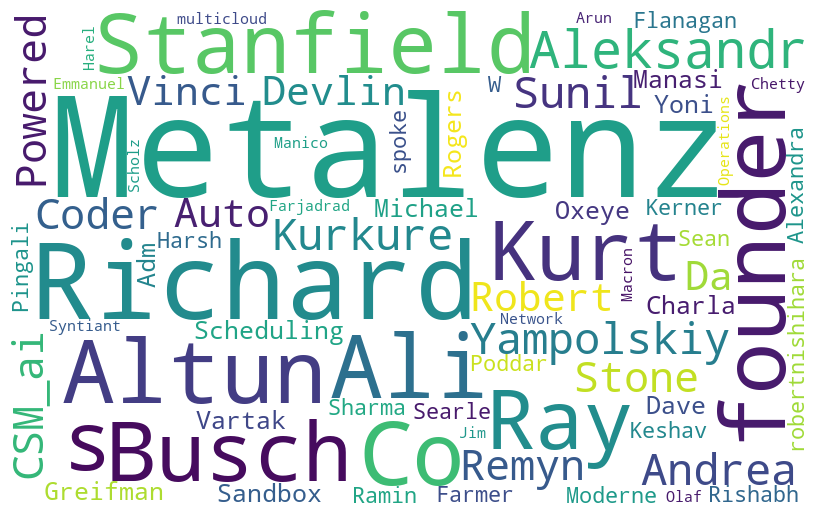

In [37]:
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt

nlp = spacy.load('en_core_web_sm')

#text = "Apple is headquartered in Cupertino, California, and employs over 100,000 people worldwide. Google, Microsoft, and Amazon are other large technology companies."

doc = nlp(text)

orgs = [ent.text for ent in doc.ents if ent.label_ == 'PERSON']

# create a string with all the organization names separated by spaces
org_string = ' '.join(orgs)

# generate the word cloud
wordcloud = WordCloud(width=800, height=500, background_color='white').generate(org_string)

# plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


/Users/ricole/opt/anaconda3/envs/berylenv/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/Users/ricole/opt/anaconda3/envs/berylenv/lib/python3.9/site-packages/wordcloud/wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/ricole/opt/anaconda3/envs/berylenv/lib/python3.9/site-packages/wordcloud/wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/ricole/opt/anaconda3/envs/berylenv/lib/python3.9/site-packages/wordcloud/wor

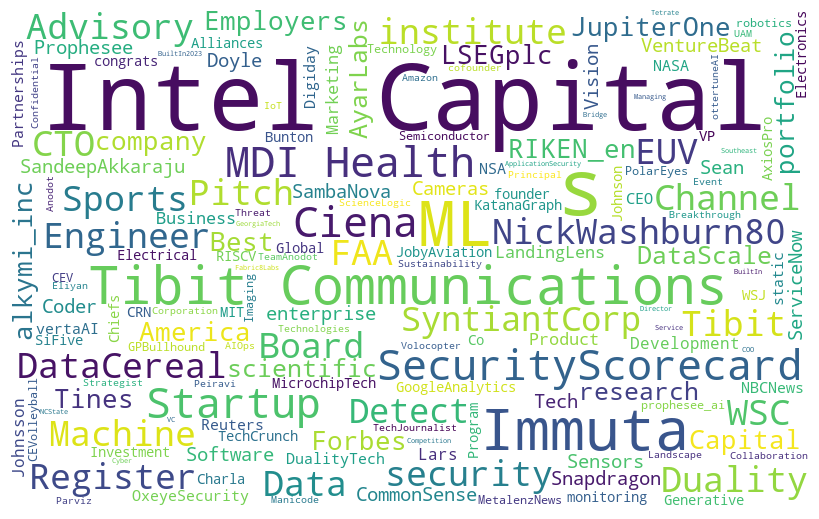

In [38]:
orgs = [ent.text for ent in doc.ents if ent.label_ == 'ORG']

# create a string with all the organization names separated by spaces
org_string = ' '.join(orgs)

# generate the word cloud
wordcloud = WordCloud(width=800, height=500, background_color='white').generate(org_string)

# plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


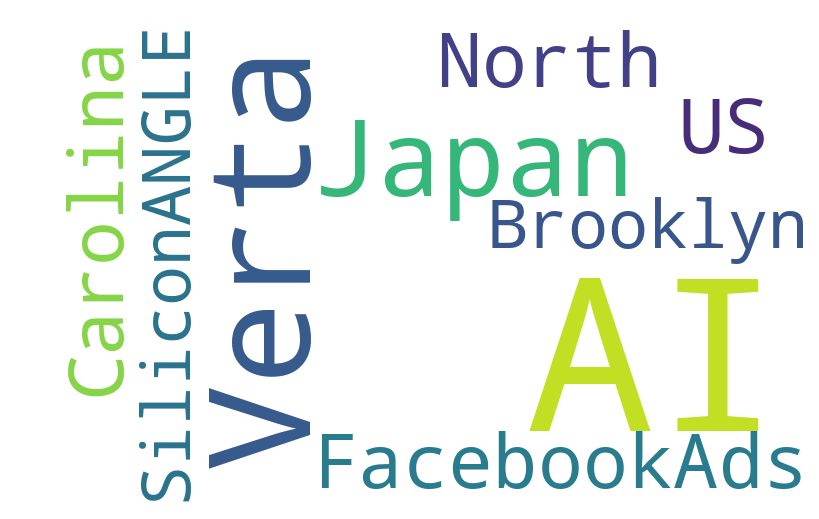

In [7]:
orgs = [ent.text for ent in doc.ents if ent.label_ == 'GPE']

# create a string with all the organization names separated by spaces
org_string = ' '.join(orgs)

# generate the word cloud
wordcloud = WordCloud(width=800, height=500, background_color='white').generate(org_string)

# plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
